# Explore regridding

This notebook is simply for exploring the regridding options via xESMF, to make sure results look OK and to get an understanding of how intensive the process can be, which is useful for calibrating slurm jobs. 

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe

from config import target_grid_fp, cmip6_dir, SCRATCH_DIR

# ignore serializationWarnings from xarray for datasets with multiple FillValues
import warnings

warnings.filterwarnings("ignore", category=xr.SerializationWarning)

Open the dataset containing the target grid. 

Shift that grid to the standard -180 to 180 grid prior to regridding.

In [2]:
dst_ds = xr.open_dataset(target_grid_fp)
lon_enc = dst_ds["lon"].encoding
lon_attrs = dst_ds["lon"].attrs
# subtract from 0-360 lon coords to get -180 to 180 lon coords, and reapply encoding
dst_ds["lon"] = dst_ds["lon"] - 180
dst_ds["lon"].encoding = lon_enc
dst_ds["lon"].attrs = lon_attrs
# sort and verify
dst_ds = dst_ds.sortby(dst_ds.lon, ascending=True)

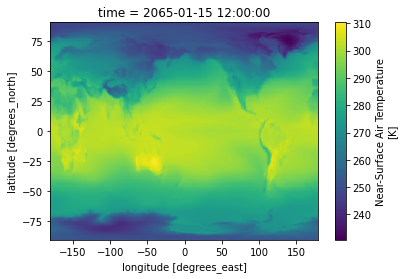

In [3]:
dst_ds.isel(time=0).tas.plot()

Open a dataset to regrid. First, try a monthly file of the same variable as the target:

In [4]:
src_fp = cmip6_dir.joinpath(
    "/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585/r1i1p1f1/Amon/tas/gn/v20200702/tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc"
)
src_ds = xr.open_dataset(src_fp)

Now regrid:

In [5]:
%%time
regridder = xe.Regridder(src_ds, dst_ds, 'bilinear', unmapped_to_nan=True)
regrid_ds = regridder(src_ds, keep_attrs=True)

CPU times: user 3.6 s, sys: 439 ms, total: 4.04 s
Wall time: 4.18 s


View the results (original on the left):

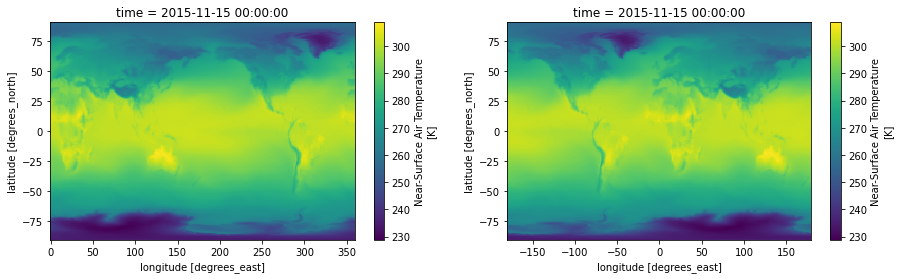

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
src_ds["tas"].isel(time=10).plot(ax=ax[0])
regrid_ds["tas"].isel(time=10).plot(ax=ax[1])

Note, this does cause a line at the prime meridian for some datasets, but that might be the case with the other proposed solution as well.

For example, GFDL-ESM4 does not have data at 0 degrees longitude:

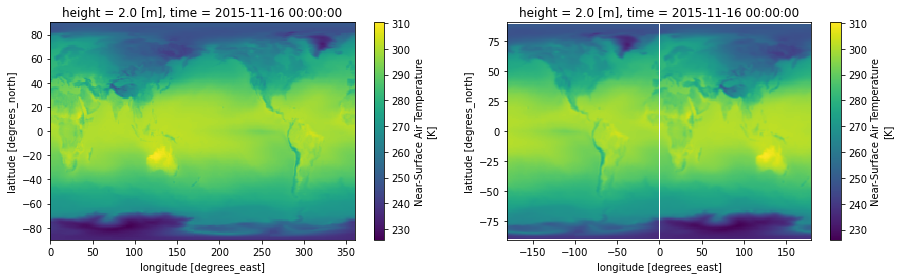

In [7]:
src_fp = cmip6_dir.joinpath(
    "ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp585/r1i1p1f1/Amon/tas/gr1/v20180701/tas_Amon_GFDL-ESM4_ssp585_r1i1p1f1_gr1_201501-210012.nc"
)
src_ds = xr.open_dataset(src_fp)

regridder = xe.Regridder(src_ds, dst_ds, "bilinear", unmapped_to_nan=True)
regrid_ds = regridder(src_ds, keep_attrs=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
src_ds["tas"].isel(time=10).plot(ax=ax[0])
regrid_ds["tas"].isel(time=10).plot(ax=ax[1])

But I don't know if this is really an issue. Can consider interpolation. 

Now ensure that we can use the same regridding object on a file with a different number of time steps (e.g. a daily file) but with the same grid. This will help us be more efficient. According to the docs, [this should be acceptable](https://xesmf.readthedocs.io/en/latest/notebooks/Reuse_regridder.html).

In [8]:
daily_src_fp = cmip6_dir.joinpath(
    "ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp585/r1i1p1f1/day/tas/gr1/v20180701/tas_day_GFDL-ESM4_ssp585_r1i1p1f1_gr1_20150101-20341231.nc"
)
daily_src_ds = xr.open_dataset(daily_src_fp)

Regrid:

In [9]:
%%time
daily_regrid_ds = regridder(daily_src_ds, keep_attrs=True)

CPU times: user 8.55 s, sys: 2.97 s, total: 11.5 s
Wall time: 13.1 s


Plot results:

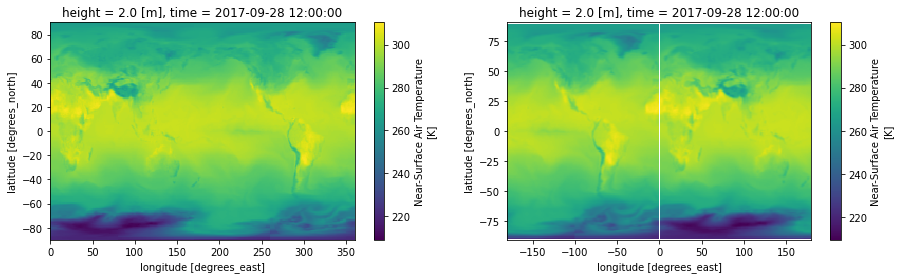

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
daily_src_ds["tas"].isel(time=1000).plot(ax=ax[0])
daily_regrid_ds["tas"].isel(time=1000).plot(ax=ax[1])

Plot the time series at a single point to make sure the broadcasting is correct (top is original):

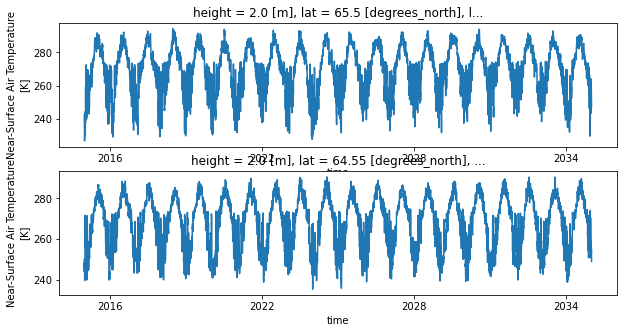

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
test_lon = 180 + (180 - 148)  # lon domain is approx (0, 360)
test_lat = 65
daily_src_ds["tas"].sel(lat=test_lat, lon=test_lon, method="nearest").plot(ax=ax[0])
daily_regrid_ds["tas"].sel(lat=test_lat, lon=test_lon, method="nearest").plot(ax=ax[1])

Great. So we can use an established `regridder` object with weights to regrid multiple files, provided they have the same grid. Also, note that regridding the daily file took approximately 30s.

## Optimizing for multiple files

This section will be used to determine a reasonable number of files to regrid in a single `sbatch` job. We will attempt to regrid a handful of daily files using `dask.delayed`, and compare.

In [11]:
import dask

Choose some daily temperature files to regrid. There should be 20 in this glob:

In [20]:
src_fps = list(
    cmip6_dir.glob(
        "ScenarioMIP/NOAA-GFDL/GFDL-ESM4/*/r1i1p1f1/day/tas/gr1/v20180701/*.nc"
    )
)
len(src_fps)

20

Define a function to regrid and write a file:

In [26]:
@dask.delayed
def regrid_file(fp, regridder, out_fp):
    src_ds = xr.open_dataset(fp)
    regrid_ds = regridder(src_ds)
    regrid_ds.to_netcdf(out_fp)

    return out_fp

Make and output dir:

In [27]:
out_dir = SCRATCH_DIR.joinpath("regrid_testing")
out_dir.mkdir(exist_ok=True)

Create the regridder object:

In [ ]:
daily_regrid_ds = regridder(daily_src_ds, keep_attrs=True)

Run the regridding:

In [30]:
results = []
for fp in src_fps:
    out_fp = out_dir.joinpath(fp.name.replace(".nc", "_regrid.nc"))
    results.append(regrid_file(fp, regridder, out_fp))

In [31]:
%%time
dask.compute(results)

CPU times: user 6min 37s, sys: 5min 27s, total: 12min 5s
Wall time: 6min 34s


([PosixPath('/center1/SNAP/kmredilla/cmip6_regridding/regrid_testing/tas_day_GFDL-ESM4_ssp245_r1i1p1f1_gr1_20350101-20541231_regrid.nc'),
  PosixPath('/center1/SNAP/kmredilla/cmip6_regridding/regrid_testing/tas_day_GFDL-ESM4_ssp245_r1i1p1f1_gr1_20750101-20941231_regrid.nc'),
  PosixPath('/center1/SNAP/kmredilla/cmip6_regridding/regrid_testing/tas_day_GFDL-ESM4_ssp245_r1i1p1f1_gr1_20550101-20741231_regrid.nc'),
  PosixPath('/center1/SNAP/kmredilla/cmip6_regridding/regrid_testing/tas_day_GFDL-ESM4_ssp245_r1i1p1f1_gr1_20950101-21001231_regrid.nc'),
  PosixPath('/center1/SNAP/kmredilla/cmip6_regridding/regrid_testing/tas_day_GFDL-ESM4_ssp245_r1i1p1f1_gr1_20150101-20341231_regrid.nc'),
  PosixPath('/center1/SNAP/kmredilla/cmip6_regridding/regrid_testing/tas_day_GFDL-ESM4_ssp370_r1i1p1f1_gr1_20350101-20541231_regrid.nc'),
  PosixPath('/center1/SNAP/kmredilla/cmip6_regridding/regrid_testing/tas_day_GFDL-ESM4_ssp370_r1i1p1f1_gr1_20750101-20941231_regrid.nc'),
  PosixPath('/center1/SNAP/kmredil

Okay this seems like an efficient and simple way to move forward. If we can process 20 daily files in under 6 minutes, we should be safe with only trying to process ~200 files in under the two hours. This should inform our generation of batch files, with each batch file containing at most 200 hundred files. 